<h2> all functions in this notebook maked to handle all data patches, put this in your mind while reading

![Read Up](https://pm1.aminoapps.com/6605/6a45ac0b3d2f533bdaa82a4b34c22b594157481c_hq.jpg)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/predicting-market-costs/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predicting-market-costs/test_data_cleaned.csv
/kaggle/input/predicting-market-costs/Train_Batch_2.csv
/kaggle/input/predicting-market-costs/Train_Batch_1.csv
/kaggle/input/predicting-market-costs/Train_Batch_3.csv
/kaggle/input/predicting-market-costs/test.csv
/kaggle/input/predicting-market-costs/train_data_cleaned.csv


In [2]:
import pandas as pd
import numpy as np
from glob import glob

glob function used to get all files names that match pattern

# Data Manipulation

In [3]:
files = glob("../input/predicting-market-costs/Train_Batch_*.csv")
files

['../input/predicting-market-costs/Train_Batch_2.csv',
 '../input/predicting-market-costs/Train_Batch_1.csv',
 '../input/predicting-market-costs/Train_Batch_3.csv']

In [4]:
dfs = [pd.read_csv(file) for file in files]
print(dfs[0].shape)
print(dfs[1].shape)
print(dfs[2].shape)

(12956, 18)
(19440, 17)
(6466, 19)


There is a problem we will enabeld to concat our data because data files have different columns shape, we need to pre-process every single file alone then concat them!

In [5]:
df1 = dfs[1].copy()
df2 = dfs[0].copy()
df3 = dfs[2].copy()

## Patch 1

In [6]:
print(df1.shape)
print(df1.info())

(19440, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19440 entries, 0 to 19439
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     19440 non-null  object 
 1   Person Description             19440 non-null  object 
 2   Place Code                     19440 non-null  object 
 3   Customer Order                 19440 non-null  object 
 4   Additional Features in market  15140 non-null  object 
 5   Promotion Name                 16530 non-null  object 
 6   Store Kind                     16530 non-null  object 
 7   Store Sales                    19440 non-null  object 
 8   Store Cost                     19440 non-null  object 
 9   Product Weights Data in (KG)   19440 non-null  object 
 10  Is Recyclable?                 19440 non-null  object 
 11  Min. Yearly Income             19437 non-null  object 
 12  Store Area                     174

In [7]:
df1.head(2)

Unnamed: 0                                 Person Description Place Code  \
0    mc_ID_0  Single Female with four children, education: b...   H11go_ZA   
1    mc_ID_1  Single Female with three children, education: ...   S04ne_WA   

                                      Customer Order  \
0  Cleaning Supplies from Household department, O...   
1  Snack Foods from Snack Foods department, Order...   

                       Additional Features in market   Promotion Name  \
0  ['Video Store', 'Florist', 'Ready Food', 'Coff...        Dimes Off   
1                                                NaN  Budget Bargains   

    Store Kind    Store Sales       Store Cost  \
0       Deluxe  8.76 Millions  4.2924 Millions   
1  Supermarket  6.36 Millions  1.9716 Millions   

                        Product Weights Data in (KG)  Is Recyclable?  \
0  {'Gross Weight': 28.1997, 'Net Weight': 26.600...      recyclable   
1  {'Gross Weight': 16.571, 'Net Weight': 14.972,...  non recyclable   

  Min. Yearly Income Store Area Grocery Area  Frozen Area Meat Area      Cost  
0               10K+    2842.23      2037.64       481.98       323  602.7575  
1               50K+    2814.95      2049.72       457.36       NaN  708.6650

first we need to set our index

In [8]:
def set_index(df):
    df = (
        df
        .rename(columns={"Unnamed: 0": "id"})
        .set_index("id")
    )
    return df

In [9]:
df1 = set_index(df1)
df1.head(2)

Person Description Place Code  \
id                                                                      
mc_ID_0  Single Female with four children, education: b...   H11go_ZA   
mc_ID_1  Single Female with three children, education: ...   S04ne_WA   

                                            Customer Order  \
id                                                           
mc_ID_0  Cleaning Supplies from Household department, O...   
mc_ID_1  Snack Foods from Snack Foods department, Order...   

                             Additional Features in market   Promotion Name  \
id                                                                            
mc_ID_0  ['Video Store', 'Florist', 'Ready Food', 'Coff...        Dimes Off   
mc_ID_1                                                NaN  Budget Bargains   

          Store Kind    Store Sales       Store Cost  \
id                                                     
mc_ID_0       Deluxe  8.76 Millions  4.2924 Millions   
mc_ID_1  Supermarket  6.36 Millions  1.9716 Millions   

                              Product Weights Data in (KG)  Is Recyclable?  \
id                                                                           
mc_ID_0  {'Gross Weight': 28.1997, 'Net Weight': 26.600...      recyclable   
mc_ID_1  {'Gross Weight': 16.571, 'Net Weight': 14.972,...  non recyclable   

        Min. Yearly Income Store Area Grocery Area  Frozen Area Meat Area  \
id                                                                          
mc_ID_0               10K+    2842.23      2037.64       481.98       323   
mc_ID_1               50K+    2814.95      2049.72       457.36       NaN   

             Cost  
id                 
mc_ID_0  602.7575  
mc_ID_1  708.6650

now we need to split `Person Description` column into `Education Work`, `Marriage`, `Gender`, `Children`, `Degree`, `Work` 

In [10]:
def split_person_description(df):
    
    df[["personal", "Degree Work"]] = (
        df["Person Description"]
        .str
        .split(", education: ", expand=True)
    )
    
    df[["Marriage", "Gender", "blank1", "Children", "blank2"]] = (
        df["personal"]
        .str
        .split(expand=True)
    )
    
    df[["Degree", "Work"]] = (
        df["Degree Work"]
        .str
        .split("working as", expand=True)
    )
    
    df = df.drop(columns=["Person Description", "personal", "blank1", "blank2"])
    return df

In [11]:
df1 = split_person_description(df1)
df1.head(2)

Place Code                                     Customer Order  \
id                                                                      
mc_ID_0   H11go_ZA  Cleaning Supplies from Household department, O...   
mc_ID_1   S04ne_WA  Snack Foods from Snack Foods department, Order...   

                             Additional Features in market   Promotion Name  \
id                                                                            
mc_ID_0  ['Video Store', 'Florist', 'Ready Food', 'Coff...        Dimes Off   
mc_ID_1                                                NaN  Budget Bargains   

          Store Kind    Store Sales       Store Cost  \
id                                                     
mc_ID_0       Deluxe  8.76 Millions  4.2924 Millions   
mc_ID_1  Supermarket  6.36 Millions  1.9716 Millions   

                              Product Weights Data in (KG)  Is Recyclable?  \
id                                                                           
mc_ID_0  {'Gross Weight': 28.1997, 'Net Weight': 26.600...      recyclable   
mc_ID_1  {'Gross Weight': 16.571, 'Net Weight': 14.972,...  non recyclable   

        Min. Yearly Income  ... Grocery Area Frozen Area  Meat Area      Cost  \
id                          ...                                                 
mc_ID_0               10K+  ...      2037.64      481.98        323  602.7575   
mc_ID_1               50K+  ...      2049.72      457.36        NaN  708.6650   

                                      Degree Work Marriage  Gender Children  \
id                                                                            
mc_ID_0  bachelors degree working as professional   Single  Female     four   
mc_ID_1    bachelors degree working as management   Single  Female    three   

                    Degree           Work  
id                                         
mc_ID_0  bachelors degree    professional  
mc_ID_1  bachelors degree      management  

[2 rows x 21 columns]

in `Place Code` column you will see something, that is the second part isn't unique but the first one is unique

In [12]:
df1["Place Code"].value_counts()

Place Code
T02ma_WA    1802
S01em_OR    1771
P07nd_OR    1668
S03le_WA    1626
H11go_ZA    1508
M10da_YU    1452
S04ne_WA    1411
B06ls_CA    1355
L05es_CA    1322
B14on_WA    1109
V13er_BC    1073
O09ba_VE     861
C15ho_ZA     769
A17co_GU     503
M12ty_DF     429
S18co_CA     253
B08am_WA     228
V19ia_BC     177
G16ra_JA     123
Name: count, dtype: int64

the first part represents the store code, and the second part represents the country ISO2 code [find it here](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2). 

In [13]:
def split_place_code(df):
    df[["Store Code", "Country ISO2"]] = (
        df["Place Code"]
        .str
        .split("_", expand=True)
    )
    
    df = df.drop(columns="Place Code")
    return df

In [14]:
df1 = split_place_code(df1)
df1.head(3)

Customer Order  \
id                                                           
mc_ID_0  Cleaning Supplies from Household department, O...   
mc_ID_1  Snack Foods from Snack Foods department, Order...   
mc_ID_2  Magazines from Periodicals department, Ordered...   

                             Additional Features in market   Promotion Name  \
id                                                                            
mc_ID_0  ['Video Store', 'Florist', 'Ready Food', 'Coff...        Dimes Off   
mc_ID_1                                                NaN  Budget Bargains   
mc_ID_2                                        ['Florist']   Shelf Emptiers   

          Store Kind     Store Sales       Store Cost  \
id                                                      
mc_ID_0       Deluxe   8.76 Millions  4.2924 Millions   
mc_ID_1  Supermarket   6.36 Millions  1.9716 Millions   
mc_ID_2  Supermarket  10.86 Millions  4.4526 Millions   

                              Product Weights Data in (KG)  Is Recyclable?  \
id                                                                           
mc_ID_0  {'Gross Weight': 28.1997, 'Net Weight': 26.600...      recyclable   
mc_ID_1  {'Gross Weight': 16.571, 'Net Weight': 14.972,...  non recyclable   
mc_ID_2  {'Gross Weight': 28.6358, 'Net Weight': 27.182...      recyclable   

        Min. Yearly Income Store Area  ... Meat Area      Cost  \
id                                     ...                       
mc_ID_0               10K+    2842.23  ...       323  602.7575   
mc_ID_1               50K+    2814.95  ...       NaN  708.6650   
mc_ID_2               30K+    2192.32  ...    348.85  564.2647   

                                          Degree Work  Marriage  Gender  \
id                                                                        
mc_ID_0      bachelors degree working as professional    Single  Female   
mc_ID_1        bachelors degree working as management    Single  Female   
mc_ID_2  high school degree working as skilled manual   Married    Male   

        Children               Degree             Work Store Code Country ISO2  
id                                                                              
mc_ID_0     four    bachelors degree      professional      H11go           ZA  
mc_ID_1    three    bachelors degree        management      S04ne           WA  
mc_ID_2      two  high school degree    skilled manual      L05es           CA  

[3 rows x 22 columns]

now it's order for `Customer Order` column

In [15]:
def split_customer_order(df):
    df[["ord_dep", "Order Brand"]] = (
        df["Customer Order"]
        .str
        .split(", Ordered Brand : ", expand=True)
    )
    
    df[["Order", "Department", "blank"]] = (
        df["ord_dep"]
        .str
        .split("from | department", expand=True)
    )
        
    df = df.drop(columns=["Customer Order", "ord_dep", "blank"])
    return df

In [16]:
df1 = split_customer_order(df1)
df1.head(3)

Additional Features in market   Promotion Name  \
id                                                                            
mc_ID_0  ['Video Store', 'Florist', 'Ready Food', 'Coff...        Dimes Off   
mc_ID_1                                                NaN  Budget Bargains   
mc_ID_2                                        ['Florist']   Shelf Emptiers   

          Store Kind     Store Sales       Store Cost  \
id                                                      
mc_ID_0       Deluxe   8.76 Millions  4.2924 Millions   
mc_ID_1  Supermarket   6.36 Millions  1.9716 Millions   
mc_ID_2  Supermarket  10.86 Millions  4.4526 Millions   

                              Product Weights Data in (KG)  Is Recyclable?  \
id                                                                           
mc_ID_0  {'Gross Weight': 28.1997, 'Net Weight': 26.600...      recyclable   
mc_ID_1  {'Gross Weight': 16.571, 'Net Weight': 14.972,...  non recyclable   
mc_ID_2  {'Gross Weight': 28.6358, 'Net Weight': 27.182...      recyclable   

        Min. Yearly Income Store Area Grocery Area  ...  Marriage  Gender  \
id                                                  ...                     
mc_ID_0               10K+    2842.23      2037.64  ...    Single  Female   
mc_ID_1               50K+    2814.95      2049.72  ...    Single  Female   
mc_ID_2               30K+    2192.32      1322.21  ...   Married    Male   

         Children               Degree             Work Store Code  \
id                                                                   
mc_ID_0      four    bachelors degree      professional      H11go   
mc_ID_1     three    bachelors degree        management      S04ne   
mc_ID_2       two  high school degree    skilled manual      L05es   

        Country ISO2 Order Brand               Order   Department  
id                                                                 
mc_ID_0           ZA    Red Wing  Cleaning Supplies     Household  
mc_ID_1           WA   Nationeel        Snack Foods   Snack Foods  
mc_ID_2           CA       Excel          Magazines   Periodicals  

[3 rows x 24 columns]

with `Additional Features in market` column we will split & encode the column into his categories then sum them all and put them in a new column `Amenities Score`

In [17]:
def encode_market_features(df):
    unique_feat = set()
    
    for feat_list in df["Additional Features in market"] :
        if pd.notna(feat_list):
            string_data = feat_list.strip("[]")
            elements = string_data.split(', ')
            elements = [element.strip("'") for element in elements]
            unique_feat.update(elements)

    for feat in unique_feat:
        df[feat] = (
            df["Additional Features in market"]
            .apply(lambda x: 1 if pd.notna(x) and feat in x else 0)
        )
        
    # Amenities Score
    df['Amenities Score'] = (
        df['Coffee Bar'].astype(int) + 
        df['Video Store'].astype(int) + 
        df['Bar For Salad'].astype(int) + 
        df['Florist'].astype(int) +
        df['Ready Food'].astype(int)
    )
    
    df = df.drop(columns=["Additional Features in market",
                          "Bar For Salad",
                          "Ready Food",
                          "Florist",
                          "Coffee Bar",
                          "Video Store"])
    return df

In [18]:
df1 = encode_market_features(df1)
df1.head(3)

Promotion Name   Store Kind     Store Sales       Store Cost  \
id                                                                       
mc_ID_0        Dimes Off       Deluxe   8.76 Millions  4.2924 Millions   
mc_ID_1  Budget Bargains  Supermarket   6.36 Millions  1.9716 Millions   
mc_ID_2   Shelf Emptiers  Supermarket  10.86 Millions  4.4526 Millions   

                              Product Weights Data in (KG)  Is Recyclable?  \
id                                                                           
mc_ID_0  {'Gross Weight': 28.1997, 'Net Weight': 26.600...      recyclable   
mc_ID_1  {'Gross Weight': 16.571, 'Net Weight': 14.972,...  non recyclable   
mc_ID_2  {'Gross Weight': 28.6358, 'Net Weight': 27.182...      recyclable   

        Min. Yearly Income Store Area Grocery Area  Frozen Area  ...  Gender  \
id                                                               ...           
mc_ID_0               10K+    2842.23      2037.64       481.98  ...  Female   
mc_ID_1               50K+    2814.95      2049.72       457.36  ...  Female   
mc_ID_2               30K+    2192.32      1322.21       523.32  ...    Male   

         Children               Degree             Work Store Code  \
id                                                                   
mc_ID_0      four    bachelors degree      professional      H11go   
mc_ID_1     three    bachelors degree        management      S04ne   
mc_ID_2       two  high school degree    skilled manual      L05es   

        Country ISO2 Order Brand               Order   Department  \
id                                                                  
mc_ID_0           ZA    Red Wing  Cleaning Supplies     Household   
mc_ID_1           WA   Nationeel        Snack Foods   Snack Foods   
mc_ID_2           CA       Excel          Magazines   Periodicals   

        Amenities Score  
id                       
mc_ID_0               5  
mc_ID_1               0  
mc_ID_2               1  

[3 rows x 24 columns]

In [19]:
df1["Promotion Name"].value_counts()

Promotion Name
Save Price                  676
Weekend Discount            660
Two Day Sale                633
Price Winners               579
Super Savers                568
Save It (Sale)              541
One Day Sale                519
Super Duper Savers          508
Roller Savings (High)       497
GLD                         478
Price Slashers              476
Full Free                   463
Shelf Clearing Days         459
Sale : Double Down          457
Lottery Cash Registerion    418
Two for One                 407
Big Time Discounts          400
Go For It                   394
Money Savers                379
Price Destroyers            369
Budget Bargains             360
Saving Days                 351
Discount Frenzy             332
Best Price Savers           327
Price Cutters               323
Dimes Off                   301
Savings Galore              298
Bag Stuffer                 287
Promo Big                   285
You Save Days               283
Sales Days               

In [20]:
df1["Store Kind"].value_counts()

Store Kind
Supermarket      7209
Deluxe           6220
Gourmet          1821
Mid-Size          761
Small Grocery     519
Name: count, dtype: int64

`Promotion Name` & `Store Kind` looks fine for now

we need to transforme `Store Sales` & `Cost Sales` to numercial columns

In [21]:
def transform_cost_sales(df):
    df["Store Sales"] = (
        df["Store Sales"]
        .str
        .split(expand=True)[0]
        .astype(float)
    ) * 1e6
    
    df["Store Cost"] = (
        df["Store Cost"]
        .str
        .split(expand=True)[0]
        .astype(float)
    ) * 1e6
    return df

In [22]:
df1 = transform_cost_sales(df1)
df1.head(3)

Promotion Name   Store Kind  Store Sales  Store Cost  \
id                                                               
mc_ID_0        Dimes Off       Deluxe    8760000.0   4292400.0   
mc_ID_1  Budget Bargains  Supermarket    6360000.0   1971600.0   
mc_ID_2   Shelf Emptiers  Supermarket   10860000.0   4452600.0   

                              Product Weights Data in (KG)  Is Recyclable?  \
id                                                                           
mc_ID_0  {'Gross Weight': 28.1997, 'Net Weight': 26.600...      recyclable   
mc_ID_1  {'Gross Weight': 16.571, 'Net Weight': 14.972,...  non recyclable   
mc_ID_2  {'Gross Weight': 28.6358, 'Net Weight': 27.182...      recyclable   

        Min. Yearly Income Store Area Grocery Area  Frozen Area  ...  Gender  \
id                                                               ...           
mc_ID_0               10K+    2842.23      2037.64       481.98  ...  Female   
mc_ID_1               50K+    2814.95      2049.72       457.36  ...  Female   
mc_ID_2               30K+    2192.32      1322.21       523.32  ...    Male   

         Children               Degree             Work Store Code  \
id                                                                   
mc_ID_0      four    bachelors degree      professional      H11go   
mc_ID_1     three    bachelors degree        management      S04ne   
mc_ID_2       two  high school degree    skilled manual      L05es   

        Country ISO2 Order Brand               Order   Department  \
id                                                                  
mc_ID_0           ZA    Red Wing  Cleaning Supplies     Household   
mc_ID_1           WA   Nationeel        Snack Foods   Snack Foods   
mc_ID_2           CA       Excel          Magazines   Periodicals   

        Amenities Score  
id                       
mc_ID_0               5  
mc_ID_1               0  
mc_ID_2               1  

[3 rows x 24 columns]

now we need to split `Product Weights Data in (KG)` columns data

In [23]:
def extract_product_weights(df):
    if "Product Weights Data in (KG)" in df.columns:
        df[["b1", "Gross Weight", "Net Weight", "Package Weight", "b2"]] = (
            df["Product Weights Data in (KG)"]
            .str
            .split("{'Gross Weight': |, 'Net Weight': |, 'Package Weight': |}", expand=True)
        )
        
        df[["Gross Weight", "Net Weight", "Package Weight"]] = (
            df[["Gross Weight", "Net Weight", "Package Weight"]]
            .astype(float)
        )
        
        df = df.drop(columns=["b1", "b2", "Product Weights Data in (KG)"])
    elif "Weights Data" in df.columns:
        df[["b1", "Gross Weight", "Net Weight", "Package Weight", "b2"]] = (
            df["Weights Data"]
            .str
            .split("{'Gross Weight': |, 'Net Weight': |, 'Package Weight': |}", expand=True)
        )
        
        df[["Gross Weight", "Net Weight", "Package Weight"]] = (
            df[["Gross Weight", "Net Weight", "Package Weight"]]
            .astype(float)
        )
        
        df = df.drop(columns=["b1", "b2", "Weights Data"])
    return df

In [24]:
df1 = extract_product_weights(df1)
df1.head(3)

Promotion Name   Store Kind  Store Sales  Store Cost  \
id                                                               
mc_ID_0        Dimes Off       Deluxe    8760000.0   4292400.0   
mc_ID_1  Budget Bargains  Supermarket    6360000.0   1971600.0   
mc_ID_2   Shelf Emptiers  Supermarket   10860000.0   4452600.0   

         Is Recyclable? Min. Yearly Income Store Area Grocery Area  \
id                                                                   
mc_ID_0      recyclable               10K+    2842.23      2037.64   
mc_ID_1  non recyclable               50K+    2814.95      2049.72   
mc_ID_2      recyclable               30K+    2192.32      1322.21   

         Frozen Area Meat Area  ...             Work Store Code Country ISO2  \
id                              ...                                            
mc_ID_0       481.98       323  ...     professional      H11go           ZA   
mc_ID_1       457.36       NaN  ...       management      S04ne           WA   
mc_ID_2       523.32    348.85  ...   skilled manual      L05es           CA   

        Order Brand               Order   Department Amenities Score  \
id                                                                     
mc_ID_0    Red Wing  Cleaning Supplies     Household               5   
mc_ID_1   Nationeel        Snack Foods   Snack Foods               0   
mc_ID_2       Excel          Magazines   Periodicals               1   

        Gross Weight Net Weight Package Weight  
id                                              
mc_ID_0      28.1997    26.6008         1.5990  
mc_ID_1      16.5710    14.9720         1.5990  
mc_ID_2      28.6358    27.1822         1.4536  

[3 rows x 26 columns]

in the second & third patch of this data you will find that `Is Recyclable?` column has diffrenet binary unique values `Yes`, `No`, so we need to make this binary unique values same!

In [25]:
def transform_recyclable(df):
    mapping = {'recyclable': 'yes', 'non recyclable': 'no'}
    df["Is Recyclable?"] = df["Is Recyclable?"].map(mapping)
    return df

In [26]:
df1 = transform_recyclable(df1)
df1.head(3)

Promotion Name   Store Kind  Store Sales  Store Cost Is Recyclable?  \
id                                                                              
mc_ID_0        Dimes Off       Deluxe    8760000.0   4292400.0            yes   
mc_ID_1  Budget Bargains  Supermarket    6360000.0   1971600.0             no   
mc_ID_2   Shelf Emptiers  Supermarket   10860000.0   4452600.0            yes   

        Min. Yearly Income Store Area Grocery Area  Frozen Area Meat Area  \
id                                                                          
mc_ID_0               10K+    2842.23      2037.64       481.98       323   
mc_ID_1               50K+    2814.95      2049.72       457.36       NaN   
mc_ID_2               30K+    2192.32      1322.21       523.32    348.85   

         ...             Work Store Code Country ISO2 Order Brand  \
id       ...                                                        
mc_ID_0  ...     professional      H11go           ZA    Red Wing   
mc_ID_1  ...       management      S04ne           WA   Nationeel   
mc_ID_2  ...   skilled manual      L05es           CA       Excel   

                      Order   Department Amenities Score Gross Weight  \
id                                                                      
mc_ID_0  Cleaning Supplies     Household               5      28.1997   
mc_ID_1        Snack Foods   Snack Foods               0      16.5710   
mc_ID_2          Magazines   Periodicals               1      28.6358   

        Net Weight Package Weight  
id                                 
mc_ID_0    26.6008         1.5990  
mc_ID_1    14.9720         1.5990  
mc_ID_2    27.1822         1.4536  

[3 rows x 26 columns]

in every data patch you will find `Min Yearly Incom` column has different name so we need to transform it and make them all has a unique name.

In [27]:
def transform_income(df):
    if "Min. Yearly Income" in df.columns:
        df["Min. Person Yearly Income"] = (
            df["Min. Yearly Income"]
            .str
            .split("K+", expand=True)[0]
            .astype(float) * 1000
        )
        df = df.drop(columns="Min. Yearly Income")
        
    elif "Min. Person Yearly Income" in df.columns:
        df["Min. Person Yearly Income"] = (
            df["Min. Person Yearly Income"]
            .str
            .split("K+", expand=True)[0]
            .astype(float) * 1000
        )
        
    elif "Yearly Income" in df.columns:
        df["Min. Person Yearly Income"] = (
            df["Yearly Income"]
            .str
            .split("K+", expand=True)[0]
            .astype(float) * 1000
        )
        df = df.drop(columns="Yearly Income")
    return df

In [28]:
df1 = transform_income(df1)
df1.head()

Promotion Name   Store Kind  Store Sales  Store Cost Is Recyclable?  \
id                                                                              
mc_ID_0        Dimes Off       Deluxe    8760000.0   4292400.0            yes   
mc_ID_1  Budget Bargains  Supermarket    6360000.0   1971600.0             no   
mc_ID_2   Shelf Emptiers  Supermarket   10860000.0   4452600.0            yes   
mc_ID_3   Savings Galore          NaN    1980000.0    673200.0            yes   
mc_ID_4     Sale Winners       Deluxe   11560000.0   4970800.0             no   

        Store Area Grocery Area  Frozen Area Meat Area      Cost  ...  \
id                                                                ...   
mc_ID_0    2842.23      2037.64       481.98       323  602.7575  ...   
mc_ID_1    2814.95      2049.72       457.36       NaN  708.6650  ...   
mc_ID_2    2192.32      1322.21       523.32    348.85  564.2647  ...   
mc_ID_3    1974.73          NaN       440.92    293.95  724.5119  ...   
mc_ID_4     2862.3      1872.19       593.93    395.95  519.7574  ...   

        Store Code Country ISO2 Order Brand               Order   Department  \
id                                                                             
mc_ID_0      H11go           ZA    Red Wing  Cleaning Supplies     Household   
mc_ID_1      S04ne           WA   Nationeel        Snack Foods   Snack Foods   
mc_ID_2      L05es           CA       Excel          Magazines   Periodicals   
mc_ID_3      S03le           WA     Carlson              Dairy         Dairy   
mc_ID_4      M10da           YU    Hermanos         Vegetables       Produce   

        Amenities Score Gross Weight Net Weight Package Weight  \
id                                                               
mc_ID_0               5      28.1997    26.6008         1.5990   
mc_ID_1               0      16.5710    14.9720         1.5990   
mc_ID_2               1      28.6358    27.1822         1.4536   
mc_ID_3               1      14.2161    11.2944         2.9217   
mc_ID_4               5      12.6172     9.7100         2.9072   

        Min. Person Yearly Income  
id                                 
mc_ID_0                   10000.0  
mc_ID_1                   50000.0  
mc_ID_2                   30000.0  
mc_ID_3                   30000.0  
mc_ID_4                   50000.0  

[5 rows x 26 columns]

as you see below there is wrong data type columns we need to transform 

In [29]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19440 entries, mc_ID_0 to mc_ID_19354
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Promotion Name             16530 non-null  object 
 1   Store Kind                 16530 non-null  object 
 2   Store Sales                19440 non-null  float64
 3   Store Cost                 19440 non-null  float64
 4   Is Recyclable?             19440 non-null  object 
 5   Store Area                 17483 non-null  object 
 6   Grocery Area               17460 non-null  object 
 7   Frozen Area                17506 non-null  float64
 8   Meat Area                  17492 non-null  object 
 9   Cost                       19416 non-null  float64
 10  Degree Work                19440 non-null  object 
 11  Marriage                   19440 non-null  object 
 12  Gender                     19440 non-null  object 
 13  Children                   19440 non-nu

In [30]:
def transform_columns_type(df):
    df["Store Area"] = (
        df["Store Area"]
        .replace('missing', float('nan'))
        .astype(float)
    )
    
    df["Grocery Area"] = (
        df["Grocery Area"]
        .str
        .strip('"')
        .replace('missing', float('nan'))
        .astype(float)
    )
    
    df["Meat Area"] = (
        df["Meat Area"]
        .str
        .strip('"')
        .astype(float)
    )
    
    trans = ["Gross Weight", "Net Weight", "Package Weight"]
    
    df[trans] = df[trans].astype(float)
    
    return df

In [31]:
df1 = transform_columns_type(df1)
df1.head()

Promotion Name   Store Kind  Store Sales  Store Cost Is Recyclable?  \
id                                                                              
mc_ID_0        Dimes Off       Deluxe    8760000.0   4292400.0            yes   
mc_ID_1  Budget Bargains  Supermarket    6360000.0   1971600.0             no   
mc_ID_2   Shelf Emptiers  Supermarket   10860000.0   4452600.0            yes   
mc_ID_3   Savings Galore          NaN    1980000.0    673200.0            yes   
mc_ID_4     Sale Winners       Deluxe   11560000.0   4970800.0             no   

         Store Area  Grocery Area  Frozen Area  Meat Area      Cost  ...  \
id                                                                   ...   
mc_ID_0     2842.23       2037.64       481.98     323.00  602.7575  ...   
mc_ID_1     2814.95       2049.72       457.36        NaN  708.6650  ...   
mc_ID_2     2192.32       1322.21       523.32     348.85  564.2647  ...   
mc_ID_3     1974.73           NaN       440.92     293.95  724.5119  ...   
mc_ID_4     2862.30       1872.19       593.93     395.95  519.7574  ...   

        Store Code Country ISO2 Order Brand               Order   Department  \
id                                                                             
mc_ID_0      H11go           ZA    Red Wing  Cleaning Supplies     Household   
mc_ID_1      S04ne           WA   Nationeel        Snack Foods   Snack Foods   
mc_ID_2      L05es           CA       Excel          Magazines   Periodicals   
mc_ID_3      S03le           WA     Carlson              Dairy         Dairy   
mc_ID_4      M10da           YU    Hermanos         Vegetables       Produce   

        Amenities Score Gross Weight Net Weight Package Weight  \
id                                                               
mc_ID_0               5      28.1997    26.6008         1.5990   
mc_ID_1               0      16.5710    14.9720         1.5990   
mc_ID_2               1      28.6358    27.1822         1.4536   
mc_ID_3               1      14.2161    11.2944         2.9217   
mc_ID_4               5      12.6172     9.7100         2.9072   

        Min. Person Yearly Income  
id                                 
mc_ID_0                   10000.0  
mc_ID_1                   50000.0  
mc_ID_2                   30000.0  
mc_ID_3                   30000.0  
mc_ID_4                   50000.0  

[5 rows x 26 columns]

now our first data patch are completly fine

## Patch 2

In [32]:
print(df2.shape)
df2.head(3)

(12956, 18)


Unnamed: 0                                 Person Description Place Code  \
0    mc_ID_0  Single Male with two children, education: high...   S01em_OR   
1    mc_ID_1  Married Male with four children, education: hi...   T02ma_WA   
2    mc_ID_2  Married Female with three children, education:...   S04ne_WA   

                                      Customer Order  \
0  Baking Goods from Baking Goods department, Ord...   
1  Canned Sardines from Canned Foods department, ...   
2  Frozen Desserts from Frozen Foods department, ...   

                       Additional Features in market   Promotion Name  \
0  ['Video Store', 'Florist', 'Ready Food', 'Bar ...  Tip Top Savings   
1  ['Florist', 'Bar For Salad', 'Ready Food', 'Co...  Discount Frenzy   
2                                                 []  Tip Top Savings   

    Store Kind Store Sales Store Cost  Gross Weight  Net Weight  \
0       Deluxe      3.28 M    0.984 M       21.9493     19.0421   
1       Deluxe      9.35 M   4.2075 M       19.1874     16.1349   
2  Supermarket       8.4 M    3.192 M       16.7163     12.3555   

  Is Recyclable? Min. Person Yearly Income  Store Area  Grocery Area  \
0            yes                      30K+     2577.50       1734.50   
1            yes                      30K+     3145.51       2057.74   
2             no                      30K+     2811.99       2049.72   

  Frozen Area  Meat Area      Cost  
0      503.07     335.38  287.1270  
1      654.13        NaN  779.6884  
2      457.36     304.91  557.8318

In [33]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12956 entries, 0 to 12955
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     12956 non-null  object 
 1   Person Description             12956 non-null  object 
 2   Place Code                     12956 non-null  object 
 3   Customer Order                 12954 non-null  object 
 4   Additional Features in market  12956 non-null  object 
 5   Promotion Name                 11665 non-null  object 
 6   Store Kind                     11683 non-null  object 
 7   Store Sales                    12955 non-null  object 
 8   Store Cost                     12956 non-null  object 
 9   Gross Weight                   11014 non-null  float64
 10  Net Weight                     11018 non-null  float64
 11  Is Recyclable?                 12956 non-null  object 
 12  Min. Person Yearly Income      12952 non-null 

we will do the same steps on patch two as patch one
- set index
- split person description
- split place code
- split customer order
- encode market features
- transform store cost & store sales
- transform person income

In [34]:
df2 = set_index(df2)
df2 = split_person_description(df2)
df2 = split_place_code(df2)
df2 = split_customer_order(df2)
df2 = encode_market_features(df2)
df2 = transform_cost_sales(df2)
df2 = transform_income(df2)
# df2 = transform_columns_type(df2)
df2.head()

Promotion Name   Store Kind  Store Sales  Store Cost  Gross Weight  \
id                                                                             
mc_ID_0  Tip Top Savings       Deluxe    3280000.0    984000.0       21.9493   
mc_ID_1  Discount Frenzy       Deluxe    9350000.0   4207500.0       19.1874   
mc_ID_2  Tip Top Savings  Supermarket    8400000.0   3192000.0       16.7163   
mc_ID_3    Price Cutters          NaN    4600000.0   1518000.0       24.1296   
mc_ID_4     Money Savers  Supermarket    6810000.0   3200700.0       17.8792   

         Net Weight Is Recyclable?  Min. Person Yearly Income  Store Area  \
id                                                                          
mc_ID_0     19.0421            yes                    30000.0     2577.50   
mc_ID_1     16.1349            yes                    30000.0     3145.51   
mc_ID_2     12.3555             no                    30000.0     2811.99   
mc_ID_3         NaN            yes                    10000.0     2147.17   
mc_ID_4     16.4256             no                    50000.0     3685.30   

         Grocery Area  ... Children                Degree             Work  \
id                     ...                                                   
mc_ID_0       1734.50  ...      two   high school degree            manual   
mc_ID_1       2057.74  ...     four   high school degree            manual   
mc_ID_2       2049.72  ...    three      partial college      professional   
mc_ID_3           NaN  ...     four  partial high school            manual   
mc_ID_4       2265.90  ...     four  partial high school    skilled manual   

        Store Code Country ISO2 Order Brand             Order    Department  \
id                                                                            
mc_ID_0      S01em           OR   Landslide     Baking Goods   Baking Goods   
mc_ID_1      T02ma           WA    Pleasant  Canned Sardines   Canned Foods   
mc_ID_2      S04ne           WA  Carrington  Frozen Desserts   Frozen Foods   
mc_ID_3      V13er           BC     PigTail  Frozen Desserts   Frozen Foods   
mc_ID_4      B14on           WA        Moms             Meat           Deli   

           Amenities Score  
id                          
mc_ID_0  1               5  
mc_ID_1  1               4  
mc_ID_2  1               0  
mc_ID_3  1               5  
mc_ID_4  1               2  

[5 rows x 26 columns]

**Oops!**

`Package Weight` column isn't found!!!!!

we need to calculate it `Package Weight` = `Gross Weight` - `Net Weight`

In [35]:
def calculate_package_weight(df):
    df["Package Weight"] = df["Gross Weight"] - df["Net Weight"]
    return df

In [36]:
df2 = calculate_package_weight(df2)
df2.head()

Promotion Name   Store Kind  Store Sales  Store Cost  Gross Weight  \
id                                                                             
mc_ID_0  Tip Top Savings       Deluxe    3280000.0    984000.0       21.9493   
mc_ID_1  Discount Frenzy       Deluxe    9350000.0   4207500.0       19.1874   
mc_ID_2  Tip Top Savings  Supermarket    8400000.0   3192000.0       16.7163   
mc_ID_3    Price Cutters          NaN    4600000.0   1518000.0       24.1296   
mc_ID_4     Money Savers  Supermarket    6810000.0   3200700.0       17.8792   

         Net Weight Is Recyclable?  Min. Person Yearly Income  Store Area  \
id                                                                          
mc_ID_0     19.0421            yes                    30000.0     2577.50   
mc_ID_1     16.1349            yes                    30000.0     3145.51   
mc_ID_2     12.3555             no                    30000.0     2811.99   
mc_ID_3         NaN            yes                    10000.0     2147.17   
mc_ID_4     16.4256             no                    50000.0     3685.30   

         Grocery Area  ...                Degree             Work  Store Code  \
id                     ...                                                      
mc_ID_0       1734.50  ...   high school degree            manual       S01em   
mc_ID_1       2057.74  ...   high school degree            manual       T02ma   
mc_ID_2       2049.72  ...      partial college      professional       S04ne   
mc_ID_3           NaN  ...  partial high school            manual       V13er   
mc_ID_4       2265.90  ...  partial high school    skilled manual       B14on   

        Country ISO2 Order Brand             Order    Department     \
id                                                                    
mc_ID_0           OR   Landslide     Baking Goods   Baking Goods  1   
mc_ID_1           WA    Pleasant  Canned Sardines   Canned Foods  1   
mc_ID_2           WA  Carrington  Frozen Desserts   Frozen Foods  1   
mc_ID_3           BC     PigTail  Frozen Desserts   Frozen Foods  1   
mc_ID_4           WA        Moms             Meat           Deli  1   

        Amenities Score Package Weight  
id                                      
mc_ID_0               5         2.9072  
mc_ID_1               4         3.0525  
mc_ID_2               0         4.3608  
mc_ID_3               5            NaN  
mc_ID_4               2         1.4536  

[5 rows x 27 columns]

In [37]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12956 entries, mc_ID_0 to mc_ID_12955
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Promotion Name             11665 non-null  object 
 1   Store Kind                 11683 non-null  object 
 2   Store Sales                12955 non-null  float64
 3   Store Cost                 12956 non-null  float64
 4   Gross Weight               11014 non-null  float64
 5   Net Weight                 11018 non-null  float64
 6   Is Recyclable?             12956 non-null  object 
 7   Min. Person Yearly Income  12952 non-null  float64
 8   Store Area                 11663 non-null  float64
 9   Grocery Area               11658 non-null  float64
 10  Frozen Area                11657 non-null  object 
 11  Meat Area                  11688 non-null  float64
 12  Cost                       12953 non-null  float64
 13  Degree Work                12956 non-nu

hmmm!

this data looks clean but if you tried it as it's you will find a blank column has unique value is `1` we need to drop it, and there is another issue that `Frozen Area` column is string not float and there is wronge values like `302.61.` we need to handle it too!

In [38]:
df2["Frozen Area"] = (
    df2["Frozen Area"][(df2["Frozen Area"] != '""')]
    .str
    .rstrip('.')
    .astype(float)
)
df2 = df2.drop(columns="")
df2.head()

Promotion Name   Store Kind  Store Sales  Store Cost  Gross Weight  \
id                                                                             
mc_ID_0  Tip Top Savings       Deluxe    3280000.0    984000.0       21.9493   
mc_ID_1  Discount Frenzy       Deluxe    9350000.0   4207500.0       19.1874   
mc_ID_2  Tip Top Savings  Supermarket    8400000.0   3192000.0       16.7163   
mc_ID_3    Price Cutters          NaN    4600000.0   1518000.0       24.1296   
mc_ID_4     Money Savers  Supermarket    6810000.0   3200700.0       17.8792   

         Net Weight Is Recyclable?  Min. Person Yearly Income  Store Area  \
id                                                                          
mc_ID_0     19.0421            yes                    30000.0     2577.50   
mc_ID_1     16.1349            yes                    30000.0     3145.51   
mc_ID_2     12.3555             no                    30000.0     2811.99   
mc_ID_3         NaN            yes                    10000.0     2147.17   
mc_ID_4     16.4256             no                    50000.0     3685.30   

         Grocery Area  ...  Children                Degree             Work  \
id                     ...                                                    
mc_ID_0       1734.50  ...       two   high school degree            manual   
mc_ID_1       2057.74  ...      four   high school degree            manual   
mc_ID_2       2049.72  ...     three      partial college      professional   
mc_ID_3           NaN  ...      four  partial high school            manual   
mc_ID_4       2265.90  ...      four  partial high school    skilled manual   

        Store Code Country ISO2 Order Brand             Order    Department  \
id                                                                            
mc_ID_0      S01em           OR   Landslide     Baking Goods   Baking Goods   
mc_ID_1      T02ma           WA    Pleasant  Canned Sardines   Canned Foods   
mc_ID_2      S04ne           WA  Carrington  Frozen Desserts   Frozen Foods   
mc_ID_3      V13er           BC     PigTail  Frozen Desserts   Frozen Foods   
mc_ID_4      B14on           WA        Moms             Meat           Deli   

        Amenities Score Package Weight  
id                                      
mc_ID_0               5         2.9072  
mc_ID_1               4         3.0525  
mc_ID_2               0         4.3608  
mc_ID_3               5            NaN  
mc_ID_4               2         1.4536  

[5 rows x 26 columns]

now everything is cleaned in patch two

## Patch 3

In [39]:
print(df3.shape)
df3.head(3)

(6466, 19)


Unnamed: 0                               Person%20Description Place%20Code  \
0    mc_ID_0  Single Female with two children, education: pa...     T02ma_WA   
1    mc_ID_1  Single Female with five children, education: p...     M10da_YU   
2    mc_ID_2  Married Male with three children, education: h...     T02ma_WA   

                                    Customer%20Order  \
0  Meat from Deli department, Ordered Brand : Red...   
1  Specialty from Produce department, Ordered Bra...   
2  Paper Products from Household department, Orde...   

                 Additional%20Features%20in%20market    Promotion%20Name  \
0  ['Coffee Bar', 'Florist', 'Ready Food', 'Bar F...  Sale : Double Down   
1  ['Coffee Bar', 'Florist', 'Bar For Salad', 'Vi...                 GLD   
2  ['Coffee Bar', 'Bar For Salad', 'Ready Food', ...           Promo Big   

  Store%20Kind   Store%20Sales     Store%20Cost  Gross%20Weight  Net%20Weight  \
0       Deluxe   7.12 Millions  2.5632 Millions         23.2575       20.3503   
1       Deluxe  14.72 Millions  7.0656 Millions         16.7163       12.3555   
2       Deluxe   4.98 Millions  2.4402 Millions         10.5531        7.6459   

                                      Weights%20Data Is%20Recyclable?  \
0  {'Gross Weight': 23.2575, 'Net Weight': 20.350...              yes   
1  {'Gross Weight': 16.7163, 'Net Weight': 12.355...              yes   
2  {'Gross Weight': 10.5531, 'Net Weight': 7.6459...               no   

  Yearly%20Income  Store%20Area  Grocery%20Area  Frozen%20Area  Meat%20Area  \
0            90K+       3145.51         2056.79         654.13       436.09   
1            30K+       2856.68         1871.16         595.93       395.51   
2            30K+       3140.99         2055.29         654.13       436.09   

       Cost  
0  500.7202  
1  484.1411  
2  267.3576

In [40]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6466 entries, 0 to 6465
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Unnamed: 0                           6466 non-null   object 
 1   Person%20Description                 6466 non-null   object 
 2   Place%20Code                         6466 non-null   object 
 3   Customer%20Order                     6466 non-null   object 
 4   Additional%20Features%20in%20market  6466 non-null   object 
 5   Promotion%20Name                     4839 non-null   object 
 6   Store%20Kind                         4840 non-null   object 
 7   Store%20Sales                        6452 non-null   object 
 8   Store%20Cost                         6459 non-null   object 
 9   Gross%20Weight                       5491 non-null   float64
 10  Net%20Weight                         5511 non-null   float64
 11  Weights%20Data                

OOOHHHHH WHAT THIS `%20` IN COLUMN NAME???????????????????????????

In [41]:
df3.columns = df3.columns.str.replace('%20', ' ')
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6466 entries, 0 to 6465
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     6466 non-null   object 
 1   Person Description             6466 non-null   object 
 2   Place Code                     6466 non-null   object 
 3   Customer Order                 6466 non-null   object 
 4   Additional Features in market  6466 non-null   object 
 5   Promotion Name                 4839 non-null   object 
 6   Store Kind                     4840 non-null   object 
 7   Store Sales                    6452 non-null   object 
 8   Store Cost                     6459 non-null   object 
 9   Gross Weight                   5491 non-null   float64
 10  Net Weight                     5511 non-null   float64
 11  Weights Data                   6466 non-null   object 
 12  Is Recyclable?                 6464 non-null   o

now we will do the same steps on patch three as patch one & two
- set index
- split person description
- split place code
- split customer order
- encode market features
- transform store cost & store sales
- transform person income
- calculate package weight

In [42]:
df3 = set_index(df3)
df3 = split_person_description(df3)
df3 = split_place_code(df3)
df3 = split_customer_order(df3)
df3 = encode_market_features(df3)
df3 = transform_cost_sales(df3)
df3 = transform_income(df3)
# df3 = transform_columns_type(df3)
df3.head(3)

Promotion Name Store Kind  Store Sales  Store Cost  Gross Weight  \
id                                                                              
mc_ID_0  Sale : Double Down     Deluxe    7120000.0   2563200.0       23.2575   
mc_ID_1                 GLD     Deluxe   14720000.0   7065600.0       16.7163   
mc_ID_2           Promo Big     Deluxe    4980000.0   2440200.0       10.5531   

         Net Weight                                       Weights Data  \
id                                                                       
mc_ID_0     20.3503  {'Gross Weight': 23.2575, 'Net Weight': 20.350...   
mc_ID_1     12.3555  {'Gross Weight': 16.7163, 'Net Weight': 12.355...   
mc_ID_2      7.6459  {'Gross Weight': 10.5531, 'Net Weight': 7.6459...   

        Is Recyclable?  Store Area  Grocery Area  ...                Degree  \
id                                                ...                         
mc_ID_0            yes     3145.51       2056.79  ...  partial high school    
mc_ID_1            yes     2856.68       1871.16  ...  partial high school    
mc_ID_2             no     3140.99       2055.29  ...   high school degree    

                    Work  Store Code Country ISO2   Order Brand  \
id                                                                
mc_ID_0     professional       T02ma           WA     Red Spade   
mc_ID_1           manual       M10da           YU     Tell Tale   
mc_ID_2   skilled manual       T02ma           WA  High Quality   

                   Order Department    Amenities Score  \
id                                                       
mc_ID_0            Meat        Deli  1               4   
mc_ID_1       Specialty     Produce  1               5   
mc_ID_2  Paper Products   Household  1               4   

        Min. Person Yearly Income  
id                                 
mc_ID_0                   90000.0  
mc_ID_1                   30000.0  
mc_ID_2                   30000.0  

[3 rows x 27 columns]

as you see there is a column called `Weights Data` that contains `Gross Weight`, `Net Weight`, `Package Weight` but there is columns existing in the table called `Gross Weight`, `Net Weight`

sooooo what do you think which choice is the best????

- calculate `Package Weight` from this existing columns?
- extract this three columns from `Weights Data` and assign it to `Gross Weight`, `Net Weight`, `Package Weight` then drop `Weights Data`?

In [43]:
df3.isna().sum()

Promotion Name               1627
Store Kind                   1626
Store Sales                    14
Store Cost                      7
Gross Weight                  975
Net Weight                    955
Weights Data                    0
Is Recyclable?                  2
Store Area                    315
Grocery Area                  328
Frozen Area                   319
Meat Area                     333
Cost                            4
Degree Work                     0
Marriage                        0
Gender                          0
Children                        0
Degree                          0
Work                            0
Store Code                      0
Country ISO2                    0
Order Brand                     0
Order                           0
Department                      0
                                0
Amenities Score                 0
Min. Person Yearly Income       1
dtype: int64

as you see there is null values in `Gross Weight`, `Net Weight` columns, so the first choice not the best. choosing second one's will fill this nulls with actuals values for every column

In [44]:
df3 = extract_product_weights(df3)
df3 = df3.drop(columns="")
df3.head()

Promotion Name   Store Kind  Store Sales  Store Cost  \
id                                                                  
mc_ID_0  Sale : Double Down       Deluxe    7120000.0   2563200.0   
mc_ID_1                 GLD       Deluxe   14720000.0   7065600.0   
mc_ID_2           Promo Big       Deluxe    4980000.0   2440200.0   
mc_ID_3    Price Destroyers          NaN    5240000.0   2043600.0   
mc_ID_4          Save Price  Supermarket    8840000.0   3447600.0   

         Gross Weight  Net Weight Is Recyclable?  Store Area  Grocery Area  \
id                                                                           
mc_ID_0       23.2575     20.3503            yes     3145.51       2056.79   
mc_ID_1       16.7163     12.3555            yes     2856.68       1871.16   
mc_ID_2       10.5531      7.6459             no     3140.99       2055.29   
mc_ID_3       23.6936     20.6410             no     2841.35       2038.11   
mc_ID_4       13.6056     10.6839             no     3236.33       2448.37   

         Frozen Area  ...                Degree             Work Store Code  \
id                    ...                                                     
mc_ID_0       654.13  ...  partial high school      professional      T02ma   
mc_ID_1       595.93  ...  partial high school            manual      M10da   
mc_ID_2       654.13  ...   high school degree    skilled manual      T02ma   
mc_ID_3       481.98  ...  partial high school    skilled manual      H11go   
mc_ID_4       472.27  ...  partial high school        management      O09ba   

        Country ISO2   Order Brand            Order    Department  \
id                                                                  
mc_ID_0           WA     Red Spade            Meat           Deli   
mc_ID_1           YU     Tell Tale       Specialty        Produce   
mc_ID_2           WA  High Quality  Paper Products      Household   
mc_ID_3           ZA     Nationeel     Snack Foods    Snack Foods   
mc_ID_4           VE        Better     Canned Soup   Canned Foods   

        Amenities Score Min. Person Yearly Income Package Weight  
id                                                                
mc_ID_0               4                   90000.0         2.9072  
mc_ID_1               5                   30000.0         4.3608  
mc_ID_2               4                   30000.0         2.9072  
mc_ID_3               5                   10000.0         3.0525  
mc_ID_4               2                  110000.0         2.9217  

[5 rows x 26 columns]

In [45]:
df3.isna().sum()

Promotion Name               1627
Store Kind                   1626
Store Sales                    14
Store Cost                      7
Gross Weight                    0
Net Weight                      0
Is Recyclable?                  2
Store Area                    315
Grocery Area                  328
Frozen Area                   319
Meat Area                     333
Cost                            4
Degree Work                     0
Marriage                        0
Gender                          0
Children                        0
Degree                          0
Work                            0
Store Code                      0
Country ISO2                    0
Order Brand                     0
Order                           0
Department                      0
Amenities Score                 0
Min. Person Yearly Income       1
Package Weight                  0
dtype: int64

now we finished our three patches successfully, let's go to concat them in ou data frame

## Concate All Patches

In [46]:
df = pd.concat([df1, df2, df3])
print(df.shape)
df.head()

(38862, 26)


Promotion Name   Store Kind  Store Sales  Store Cost Is Recyclable?  \
id                                                                              
mc_ID_0        Dimes Off       Deluxe    8760000.0   4292400.0            yes   
mc_ID_1  Budget Bargains  Supermarket    6360000.0   1971600.0             no   
mc_ID_2   Shelf Emptiers  Supermarket   10860000.0   4452600.0            yes   
mc_ID_3   Savings Galore          NaN    1980000.0    673200.0            yes   
mc_ID_4     Sale Winners       Deluxe   11560000.0   4970800.0             no   

         Store Area  Grocery Area  Frozen Area  Meat Area      Cost  ...  \
id                                                                   ...   
mc_ID_0     2842.23       2037.64       481.98     323.00  602.7575  ...   
mc_ID_1     2814.95       2049.72       457.36        NaN  708.6650  ...   
mc_ID_2     2192.32       1322.21       523.32     348.85  564.2647  ...   
mc_ID_3     1974.73           NaN       440.92     293.95  724.5119  ...   
mc_ID_4     2862.30       1872.19       593.93     395.95  519.7574  ...   

        Store Code Country ISO2 Order Brand               Order   Department  \
id                                                                             
mc_ID_0      H11go           ZA    Red Wing  Cleaning Supplies     Household   
mc_ID_1      S04ne           WA   Nationeel        Snack Foods   Snack Foods   
mc_ID_2      L05es           CA       Excel          Magazines   Periodicals   
mc_ID_3      S03le           WA     Carlson              Dairy         Dairy   
mc_ID_4      M10da           YU    Hermanos         Vegetables       Produce   

        Amenities Score Gross Weight Net Weight Package Weight  \
id                                                               
mc_ID_0               5      28.1997    26.6008         1.5990   
mc_ID_1               0      16.5710    14.9720         1.5990   
mc_ID_2               1      28.6358    27.1822         1.4536   
mc_ID_3               1      14.2161    11.2944         2.9217   
mc_ID_4               5      12.6172     9.7100         2.9072   

        Min. Person Yearly Income  
id                                 
mc_ID_0                   10000.0  
mc_ID_1                   50000.0  
mc_ID_2                   30000.0  
mc_ID_3                   30000.0  
mc_ID_4                   50000.0  

[5 rows x 26 columns]

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38862 entries, mc_ID_0 to mc_ID_6465
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Promotion Name             33034 non-null  object 
 1   Store Kind                 33053 non-null  object 
 2   Store Sales                38847 non-null  float64
 3   Store Cost                 38855 non-null  float64
 4   Is Recyclable?             38860 non-null  object 
 5   Store Area                 35296 non-null  float64
 6   Grocery Area               35255 non-null  float64
 7   Frozen Area                35309 non-null  float64
 8   Meat Area                  35313 non-null  float64
 9   Cost                       38831 non-null  float64
 10  Degree Work                38862 non-null  object 
 11  Marriage                   38862 non-null  object 
 12  Gender                     38862 non-null  object 
 13  Children                   38862 non-nul

we don't need old index so we will reset it

In [48]:
df = df.reset_index().drop(columns="id")
df.head()

Promotion Name   Store Kind  Store Sales  Store Cost Is Recyclable?  \
0        Dimes Off       Deluxe    8760000.0   4292400.0            yes   
1  Budget Bargains  Supermarket    6360000.0   1971600.0             no   
2   Shelf Emptiers  Supermarket   10860000.0   4452600.0            yes   
3   Savings Galore          NaN    1980000.0    673200.0            yes   
4     Sale Winners       Deluxe   11560000.0   4970800.0             no   

   Store Area  Grocery Area  Frozen Area  Meat Area      Cost  ... Store Code  \
0     2842.23       2037.64       481.98     323.00  602.7575  ...      H11go   
1     2814.95       2049.72       457.36        NaN  708.6650  ...      S04ne   
2     2192.32       1322.21       523.32     348.85  564.2647  ...      L05es   
3     1974.73           NaN       440.92     293.95  724.5119  ...      S03le   
4     2862.30       1872.19       593.93     395.95  519.7574  ...      M10da   

  Country ISO2 Order Brand               Order   Department Amenities Score  \
0           ZA    Red Wing  Cleaning Supplies     Household               5   
1           WA   Nationeel        Snack Foods   Snack Foods               0   
2           CA       Excel          Magazines   Periodicals               1   
3           WA     Carlson              Dairy         Dairy               1   
4           YU    Hermanos         Vegetables       Produce               5   

  Gross Weight Net Weight Package Weight Min. Person Yearly Income  
0      28.1997    26.6008         1.5990                   10000.0  
1      16.5710    14.9720         1.5990                   50000.0  
2      28.6358    27.1822         1.4536                   30000.0  
3      14.2161    11.2944         2.9217                   30000.0  
4      12.6172     9.7100         2.9072                   50000.0  

[5 rows x 26 columns]

In [49]:
data_without_cleansing = df.copy()

# Data Cleansing

let's check if there is any duplicated values. if any drop them

In [50]:
df.duplicated().sum()

8

In [51]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [52]:
df.isna().sum()

Promotion Name               5828
Store Kind                   5808
Store Sales                    15
Store Cost                      7
Is Recyclable?                  2
Store Area                   3565
Grocery Area                 3606
Frozen Area                  3552
Meat Area                    3547
Cost                           31
Degree Work                     0
Marriage                        0
Gender                          0
Children                        0
Degree                          0
Work                            0
Store Code                      0
Country ISO2                    0
Order Brand                     2
Order                           2
Department                      2
Amenities Score                 0
Gross Weight                 1942
Net Weight                   1938
Package Weight               3578
Min. Person Yearly Income       8
dtype: int64

there is null values need us to handle it

In [53]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def fill_numerical_nulls(df):
    int_cols = df.select_dtypes(int).columns
    float_cols = df.select_dtypes(float).columns
    cat_cols = df.select_dtypes("object").columns
    
    if "Cost" in df.columns:
        
        imputer = IterativeImputer()
        df[float_cols] = imputer.fit_transform(df[float_cols])
        
        for col in int_cols:
            df[col] = (
                df[col]
                .fillna(df[col].mode()[0])
            )
        
    else:
        imputer = IterativeImputer()
        df[float_cols] = imputer.fit_transform(df[float_cols])
        
        for col in int_cols:
            df[col] = (
                df[col]
                .fillna(df[col].mode()[0])
            )
        
        for col in cat_cols:
            df[col] = (
                df[col]
                .fillna(df[col].mode()[0])
            )

    return df

we will use technique called `IterativeImputer` let's discuss what is the key advantages of it

In [54]:
null_cols = df.select_dtypes("number").isnull().any()
cols_with_nulls = null_cols[null_cols].index.tolist()
cols_with_nulls

['Store Sales',
 'Store Cost',
 'Store Area',
 'Grocery Area',
 'Frozen Area',
 'Meat Area',
 'Cost',
 'Gross Weight',
 'Net Weight',
 'Package Weight',
 'Min. Person Yearly Income']

let's look to the null columns distibution before applying `IterativeImputer`

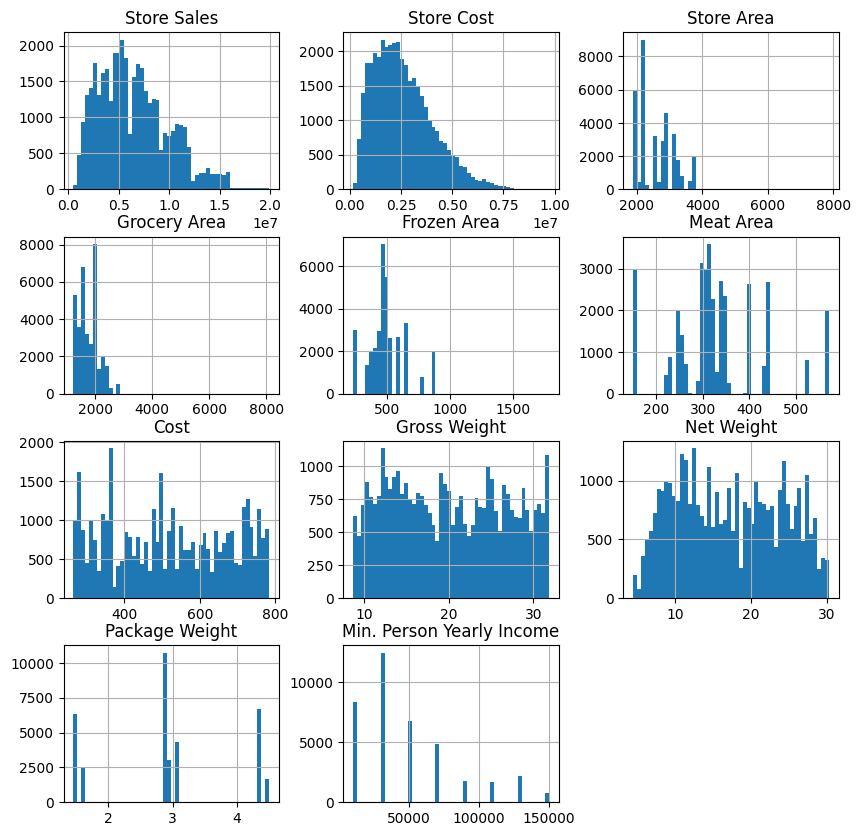

In [55]:
df[cols_with_nulls].hist(figsize=(10, 10), bins=50);

In [56]:
df = fill_numerical_nulls(df)

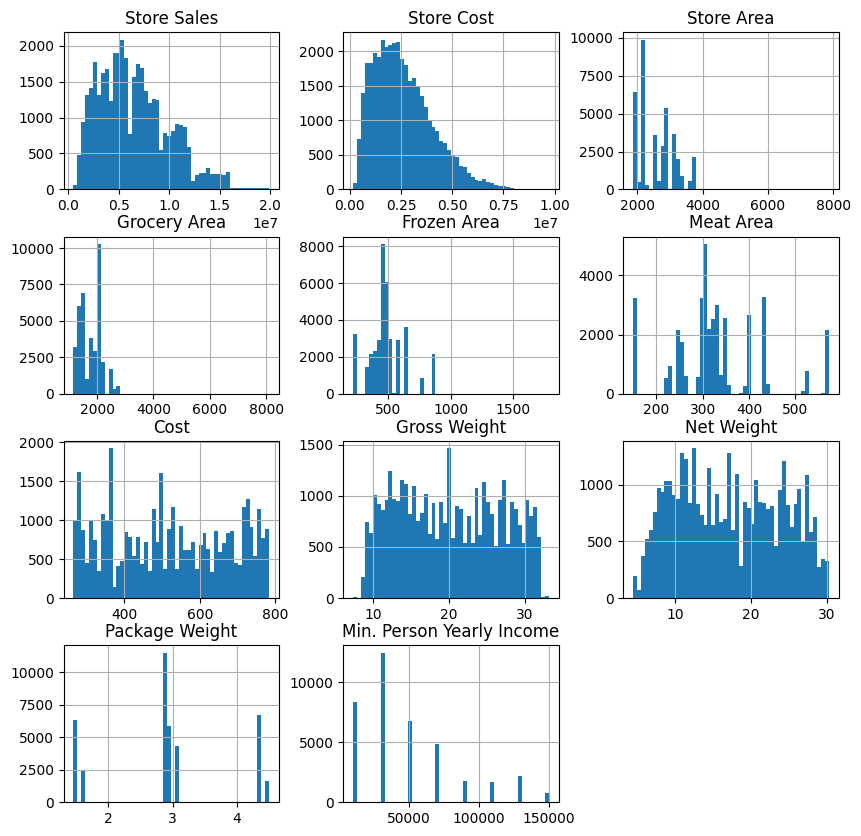

In [57]:
df[cols_with_nulls].hist(figsize=(10, 10), bins=50);

as you can see now, we have filled in the null values in an efficient way, so that we have not changed anything in the distribution. This is because there are a lot of null values, which if we used `SimpleImputer` could lead to an imbalance in the distribution, and you can try that for yourself.

In [58]:
df.isna().sum()

Promotion Name               5828
Store Kind                   5808
Store Sales                     0
Store Cost                      0
Is Recyclable?                  2
Store Area                      0
Grocery Area                    0
Frozen Area                     0
Meat Area                       0
Cost                            0
Degree Work                     0
Marriage                        0
Gender                          0
Children                        0
Degree                          0
Work                            0
Store Code                      0
Country ISO2                    0
Order Brand                     2
Order                           2
Department                      2
Amenities Score                 0
Gross Weight                    0
Net Weight                      0
Package Weight                  0
Min. Person Yearly Income       0
dtype: int64

we will drop other null values

In [59]:
df.dropna(inplace=True)
df.isna().sum()

Promotion Name               0
Store Kind                   0
Store Sales                  0
Store Cost                   0
Is Recyclable?               0
Store Area                   0
Grocery Area                 0
Frozen Area                  0
Meat Area                    0
Cost                         0
Degree Work                  0
Marriage                     0
Gender                       0
Children                     0
Degree                       0
Work                         0
Store Code                   0
Country ISO2                 0
Order Brand                  0
Order                        0
Department                   0
Amenities Score              0
Gross Weight                 0
Net Weight                   0
Package Weight               0
Min. Person Yearly Income    0
dtype: int64

save data for model building and EDA

In [60]:
# data_without_cleansing.to_csv("data_without_cleansing.csv", index=False)
# df.to_csv("train_data_cleaned.csv", index=False)

# Wrangle Test Data

test data turn to wrangling!

In [61]:
test = pd.read_csv("../input/predicting-market-costs/test.csv")
print(test.shape)
test.head(3)

(19942, 18)


Unnamed: 0                                 Person Description Place Code  \
0           0  Single Male with four children, education: par...   B06ls_CA   
1           1  Married Female with three children, education:...   S01em_OR   
2           2  Single Female with three children, education: ...   H11go_ZA   

                                      Customer Order  \
0  Candy from Snacks department, Ordered Brand : ...   
1  Vegetables from Frozen Foods department, Order...   
2  Dairy from Dairy department, Ordered Brand : Club   

                       Additional Features in market       Promotion Name  \
0  ['Florist', 'Ready Food', 'Video Store', 'Bar ...  Fantastic Discounts   
1  ['Florist', 'Coffee Bar', 'Ready Food', 'Bar F...          Bag Stuffer   
2  ['Bar For Salad', 'Video Store', 'Ready Food',...    Pick Your Savings   

  Store Kind     Store Sales       Store Cost  Gross Weight  Net Weight  \
0    Gourmet  11.76 Millions   4.704 Millions       31.8337     28.7811   
1     Deluxe   2.16 Millions  0.6696 Millions       29.9440     27.0368   
2     Deluxe   1.83 Millions  0.8235 Millions       29.2172     26.3100   

   Package Weight Is Recyclable? Yearly Income  Store Area  Grocery Area  \
0          3.0525            yes          50K+     2201.06       1424.85   
1          2.9072             no          70K+     2577.16       1735.17   
2          2.9072             no         130K+     2837.58       2038.11   

   Frozen Area  Meat Area  
0       465.54     308.73  
1       505.07     336.59  
2       481.98     321.26

In [62]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19942 entries, 0 to 19941
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     19942 non-null  int64  
 1   Person Description             19942 non-null  object 
 2   Place Code                     19942 non-null  object 
 3   Customer Order                 19942 non-null  object 
 4   Additional Features in market  19942 non-null  object 
 5   Promotion Name                 19916 non-null  object 
 6   Store Kind                     19914 non-null  object 
 7   Store Sales                    19942 non-null  object 
 8   Store Cost                     19942 non-null  object 
 9   Gross Weight                   18959 non-null  float64
 10  Net Weight                     18924 non-null  float64
 11  Package Weight                 19942 non-null  float64
 12  Is Recyclable?                 19942 non-null 

In [63]:
test.isna().sum()

Unnamed: 0                          0
Person Description                  0
Place Code                          0
Customer Order                      0
Additional Features in market       0
Promotion Name                     26
Store Kind                         28
Store Sales                         0
Store Cost                          0
Gross Weight                      983
Net Weight                       1018
Package Weight                      0
Is Recyclable?                      0
Yearly Income                       0
Store Area                        996
Grocery Area                     1042
Frozen Area                       961
Meat Area                         975
dtype: int64

In [64]:
test = set_index(test)
test = split_person_description(test)
test = split_place_code(test)
test = split_customer_order(test)
test = encode_market_features(test)
test = transform_cost_sales(test)
test = transform_income(test)
#test = pre.transform_columns_type(test)
test = fill_numerical_nulls(test)
test = test.drop(columns="")
test.head()

Promotion Name   Store Kind  Store Sales  Store Cost  Gross Weight  \
id                                                                            
0   Fantastic Discounts      Gourmet   11760000.0   4704000.0       31.8337   
1           Bag Stuffer       Deluxe    2160000.0    669600.0       29.9440   
2     Pick Your Savings       Deluxe    1830000.0    823500.0       29.2172   
3         Price Winners       Deluxe    8820000.0   4410000.0       28.0543   
4           Dollar Days  Supermarket    4320000.0   1987200.0       23.5482   

    Net Weight  Package Weight Is Recyclable?  Store Area  Grocery Area  ...  \
id                                                                       ...   
0      28.7811          3.0525            yes     2201.06       1424.85  ...   
1      27.0368          2.9072             no     2577.16       1735.17  ...   
2      26.3100          2.9072             no     2837.58       2038.11  ...   
3      25.0018          3.0525             no     2859.04       1871.16  ...   
4      20.6410          2.9072             no     2193.97       1320.15  ...   

    Children                Degree             Work Store Code Country ISO2  \
id                                                                            
0       four  partial high school    skilled manual      B06ls           CA   
1      three      graduate degree      professional      S01em           OR   
2      three  partial high school        management      H11go           ZA   
3      three  partial high school            manual      M10da           YU   
4        two   high school degree            manual      L05es           CA   

   Order Brand             Order    Department Amenities Score  \
id                                                               
0   Gulf Coast            Candy         Snacks               5   
1       Golden       Vegetables   Frozen Foods               5   
2         Club            Dairy          Dairy               5   
3      Imagine  Frozen Desserts   Frozen Foods               5   
4     BBB Best    Hot Beverages      Beverages               1   

   Min. Person Yearly Income  
id                            
0                    50000.0  
1                    70000.0  
2                   130000.0  
3                    10000.0  
4                    30000.0  

[5 rows x 25 columns]

In [65]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19942 entries, 0 to 19941
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Promotion Name             19942 non-null  object 
 1   Store Kind                 19942 non-null  object 
 2   Store Sales                19942 non-null  float64
 3   Store Cost                 19942 non-null  float64
 4   Gross Weight               19942 non-null  float64
 5   Net Weight                 19942 non-null  float64
 6   Package Weight             19942 non-null  float64
 7   Is Recyclable?             19942 non-null  object 
 8   Store Area                 19942 non-null  float64
 9   Grocery Area               19942 non-null  float64
 10  Frozen Area                19942 non-null  float64
 11  Meat Area                  19942 non-null  float64
 12  Degree Work                19942 non-null  object 
 13  Marriage                   19942 non-null  object 


In [66]:
test.isna().sum()

Promotion Name               0
Store Kind                   0
Store Sales                  0
Store Cost                   0
Gross Weight                 0
Net Weight                   0
Package Weight               0
Is Recyclable?               0
Store Area                   0
Grocery Area                 0
Frozen Area                  0
Meat Area                    0
Degree Work                  0
Marriage                     0
Gender                       0
Children                     0
Degree                       0
Work                         0
Store Code                   0
Country ISO2                 0
Order Brand                  0
Order                        0
Department                   0
Amenities Score              0
Min. Person Yearly Income    0
dtype: int64

we need now to make columns order in test patch as the same on train patch

In [67]:
test = test[df.drop(columns="Cost").columns]
test.head()

Promotion Name   Store Kind  Store Sales  Store Cost Is Recyclable?  \
id                                                                             
0   Fantastic Discounts      Gourmet   11760000.0   4704000.0            yes   
1           Bag Stuffer       Deluxe    2160000.0    669600.0             no   
2     Pick Your Savings       Deluxe    1830000.0    823500.0             no   
3         Price Winners       Deluxe    8820000.0   4410000.0             no   
4           Dollar Days  Supermarket    4320000.0   1987200.0             no   

    Store Area  Grocery Area  Frozen Area  Meat Area  \
id                                                     
0      2201.06       1424.85       465.54     308.73   
1      2577.16       1735.17       505.07     336.59   
2      2837.58       2038.11       481.98     321.26   
3      2859.04       1871.16       593.93     394.58   
4      2193.97       1320.15       523.32     348.85   

                                      Degree Work  ... Store Code  \
id                                                 ...              
0   partial high school working as skilled manual  ...      B06ls   
1         graduate degree working as professional  ...      S01em   
2       partial high school working as management  ...      H11go   
3           partial high school working as manual  ...      M10da   
4            high school degree working as manual  ...      L05es   

   Country ISO2 Order Brand             Order    Department Amenities Score  \
id                                                                            
0            CA  Gulf Coast            Candy         Snacks               5   
1            OR      Golden       Vegetables   Frozen Foods               5   
2            ZA        Club            Dairy          Dairy               5   
3            YU     Imagine  Frozen Desserts   Frozen Foods               5   
4            CA    BBB Best    Hot Beverages      Beverages               1   

   Gross Weight Net Weight Package Weight Min. Person Yearly Income  
id                                                                   
0       31.8337    28.7811         3.0525                   50000.0  
1       29.9440    27.0368         2.9072                   70000.0  
2       29.2172    26.3100         2.9072                  130000.0  
3       28.0543    25.0018         3.0525                   10000.0  
4       23.5482    20.6410         2.9072                   30000.0  

[5 rows x 25 columns]

In [68]:
# test.to_csv("test_data_cleaned.csv", index=False)

now i finished my pre-processing on market costs data if you have any comment or add please feel free to write your words